Goal: Use OOP to make in depth player analysis code reusable

In [23]:
class Player:
    def __init__(self, player, team):
        self.player = player
        self.team = team

    def setup_df(self):
            '''Set up the player's results dataframe'''
            player = self.player
            team = self.team
            import pandas as pd
            import sqlite3
            sql = 'select * from results'
            con = sqlite3.connect('../../players.db')
            dframe = pd.read_sql(sql,con,index_col=['Year','Match'])
            dframe.drop('index',axis=1,inplace=True)
            dframe['Europe_lost'] = ~ dframe['Europe_won']
            if 'a' in team.lower():
                df = dframe[dframe['American_player'].str.contains(player)]
                df = df[['Format', 'European_player', 'European_score', 'American_score',
                   'American_player', 'Europe_lost','Europe_won']]
                df.columns = ['Format', 'European_player', 'European_score', 'American_score',
                   'American_player', 'America_won', 'America_lost']
            else:
                df = dframe[dframe['European_player'].str.contains(player)]
            return(df,dframe)
    
    def stats(self,df):
        team=self.team
        try:
            if 'a' in team.lower():
                win = df['America_won'].sum()
                loss = df['America_lost'].sum()
            else:
                win = df['Europe_won'].sum()
                loss = df['Europe_lost'].sum()
            mp= win+loss
            wl = 'Win-loss: {}-{}'.format(win,loss)
            pct = round(win/(win+loss)*100,0)
            return('Matches Played: {}'.format(mp),wl,'Pct: {}'.format(pct))
        except:
            return('No matches to display')

    def overall_stats(self,df):
        team=self.team
        sing = df[df['Format']=='Singles']
        dub = df[df['Format']=='Doubles']
        teams = df[df['Format']=='Teams']
        triples = df[df['Format']=='Triples'] 
        outstr='Overall: {}\nSingles: {}\nDoubles: {}\nTeams:   {}\nTriples: {}\n'.format(self.stats(df), self.stats(sing), self.stats(dub), self.stats(teams), self.stats(triples))
        print(outstr)
        return(sing,dub,teams,triples)
    
    def partners(self,dub):
        player=self.player
        if 'America_won' in dub:
            dub = dub[['European_player','American_player','America_won','America_lost']].copy()
            dub['Partner']=dub['American_player'].str.replace(player,'')
            dub['Partner']=dub['Partner'].str.replace('&','')
            dub['Partner']=dub['Partner'].str.strip()
            d = dub.groupby('Partner').sum().sort_values(['America_won','America_lost'],ascending=False)
            return d    
        else:
            dub = dub[['European_player','American_player','Europe_won','Europe_lost']]
            dub['Partner']=dub['European_player'].str.replace(player,'')
            dub['Partner']=dub['Partner'].str.replace('&','')
            dub['Partner']=dub['Partner'].str.strip()
            return dub.groupby('Partner').sum().sort_values(['Europe_won','Europe_lost'],ascending=False)

    def opponents(self,sing):
        if 'America_won' in sing:
            return sing.groupby('European_player').sum().sort_values('America_won',ascending = False)
        else:
            return sing.groupby('American_player').sum().sort_values('Europe_won',ascending = False)
        
    def yearly_plot(self,df):
        import numpy as np
        import matplotlib.pyplot as plt
        
        lst =df.index.values.tolist() 
        years = set([])
        
        for item in lst:
            years.add(item[0])
        years=list(years)

        yearly=[]
        for year in years:
            if 'America_won' in df:
                w = df.loc[year]['America_won'].sum()
                l = df.loc[year]['America_lost'].sum()
            else:
                w = df.loc[year]['Europe_won'].sum()
                l = df.loc[year]['Europe_lost'].sum()
            yearly.append((w,l))

        yr= {}
        for k,v in zip(years,yearly):
            yr[k]=v

        win=[]
        loss=[]
        pct=[]
        for w,l in yearly:
            win.append(w)
            loss.append(l)
            p=round((w*100/(w+l)),0)
            pct.append(p)

        # from IPython.core.interactiveshell import InteractiveShell
        # InteractiveShell.ast_node_interactivity = "last_expr"

        fig = plt.figure(figsize=(14, 8))
        ax = fig.add_subplot(111)

        x= years
        y= pct

        ind = range(len(years))  

        ax.plot(y,linestyle='-',marker='.',markersize=12)
        ax.axhline(50, color='r',linestyle='--')

        ax.set_ylabel('Percentage of Games Won');
        ax.set_title('Yearly Performance Average');
        ax.set_xticks(ind);
        ax.set_xticklabels(x,rotation=30);

        for i in range(len(years)):
            plt.annotate( '{}-{}'.format(yearly[i][0],yearly[i][1]), (ind[i]+.2,y[i]) )
        plt.show()
        return years
    
    def wincount(self,dframe,years):
        team=self.team
        l=0
        w=0
        tie=0
        print('Team win-loss record by year:\n')
        for year in years:
            f,t = dframe.loc[year]['Europe_won'].value_counts(sort=False)
            print('{}: {}-{}'.format(year,f,t))
            if f>t:
                l+=1
            elif f<t:
                w+=1 
            else:
                tie+=1
        if 'a' in team:
            l,w = w,l
        print('\n')
        print( 'Total team win-loss-tie: {}-{}-{}\n'.format(w,l,tie)  )
        
    def location(self,df,years):
        team=self.team
#         import pickle
#         path = '//DREW/Users/andrew/Desktop/mosconi/'
#         locs = pickle.load(open(path+'pkl/dloc','rb'))
        import sqlite3
        sql = 'select Year, Venue from yearly'
        con = sqlite3.connect('../../players.db')
        locs = pd.read_sql(sql,con,index_col='Year')
        
        hm = []
        aw = []

        for year in years:
            if 'USA' in locs.loc[year]:
                if 'a' in team.lower():
                    hm.append(year)
                else:
                    aw.append(year)
            else:
                if 'a' in team.lower():
                    aw.append(year)
                else:
                    hm.append(year)
        away = df.loc[aw]
        home = df.loc[hm]

        print( '\t Played home {} times, away {} times \n Home Games: {} \n Away Games: {}\n'.format(len(hm),len(aw),self.stats(home),self.stats(away)))
        return(home,away)

    def location_split(self,home,away):
        team = self.team
        hsing = self.stats(home[home['Format']=='Singles'])
        hdub = self.stats(home[home['Format']=='Doubles'])
        asing = self.stats(away[away['Format']=='Singles'])
        adub = self.stats(away[away['Format']=='Doubles'])

        print(' Home Singles: {} \n Home Doubles: {} \n Away Singles: {} \n Away Doubles: {}\n'.format(hsing,hdub,asing,adub))

    def call_em(self):
        player=self.player
        team=self.team
        df,dframe = self.setup_df()
        sing,dub,teams,triples = self.overall_stats(df)
        print('-----Win-loss breakdown by partner----- \n')
        print(self.partners(dub))
        print('\n')
        print('-----Win-loss breakdown by opponent (singles)----- \n')
        print(self.opponents(sing))
        years = self.yearly_plot(df)
        self.wincount(dframe,years)
        home,away = self.location(df,years)
        self.location_split(home,away)
        return

In [7]:
svb=Player('Shane Van Boening','America')

In [8]:
svb.player

'Shane Van Boening'

In [9]:
svb.team

'America'

In [10]:
df,dframe=svb.setup_df()

In [13]:
df.head()

Format                                    European_player  \
Year Match                                                               
2007 0        Teams  Tony Drago, Niels Feijen, Konstantin Stepanov,...   
     2      Singles                                        Daryl Peach   
     5      Doubles                           Daryl Peach Ralf Souquet   
     8      Singles                                         Tony Drago   
     12     Doubles                    Konstantin Stepanov Daryl Peach   

           European_score American_score  \
Year Match                                 
2007 0                  4              6   
     2                  2              6   
     5                  6              0   
     8                  6              2   
     12                 3              6   

                                              American_player  America_won  \
Year Match                                                                   
2007 0      Johnny Archer, Rodney Morris, Corey Deuel, Ear...           -1   
     2                                      Shane Van Boening           -1   
     5                      Earl Strickland Shane Van Boening           -2   
     8                                      Shane Van Boening           -2   
     12                       Johnny Archer Shane Van Boening           -1   

            America_lost  
Year Match                
2007 0                 0  
     2                 0  
     5                 1  
     8                 1  
     12                0

In [14]:
svb.stats(df)

('Matches Played: -73', 'Win-loss: -116-43', 'Pct: 159.0')

In [15]:
sing,dub,teams,triples= svb.overall_stats(df)

Overall: ('Matches Played: -73', 'Win-loss: -116-43', 'Pct: 159.0')
Singles: ('Matches Played: -30', 'Win-loss: -47-17', 'Pct: 157.0')
Doubles: ('Matches Played: -31', 'Win-loss: -49-18', 'Pct: 158.0')
Teams:   ('Matches Played: -12', 'Win-loss: -20-8', 'Pct: 167.0')
Triples: ('Matches Played: 0', 'Win-loss: 0-0', 'Pct: nan')



C:\Users\Andrew\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in longlong_scalars


In [16]:
svb.partners(dub)

,America_won,America_lost
Partner,,
", Corey Deuel",-1,0
"Skyler Woodward,",-1,0
", Oscar Dominguez",-2,1
", Skyler Woodward",-2,1
John Schmidt,-2,1
Justin Bergman,-2,1
Oscar Dominguez,-2,1
Dennis Hatch,-2,0
Earl Strickland,-3,1


In [17]:
svb.opponents(sing)

,America_won,America_lost
European_player,,
Alexander Kazakis,-1,0
Daryl Peach,-1,0
Karl Boyes,-1,0
Konstantin Stepanov,-1,0
Chris Melling,-2,1
Nick Ekonomopoulos,-2,1
Niels Feijen,-2,1
Nikos Ekonomopoulos,-2,1
Nick van den Berg,-3,0


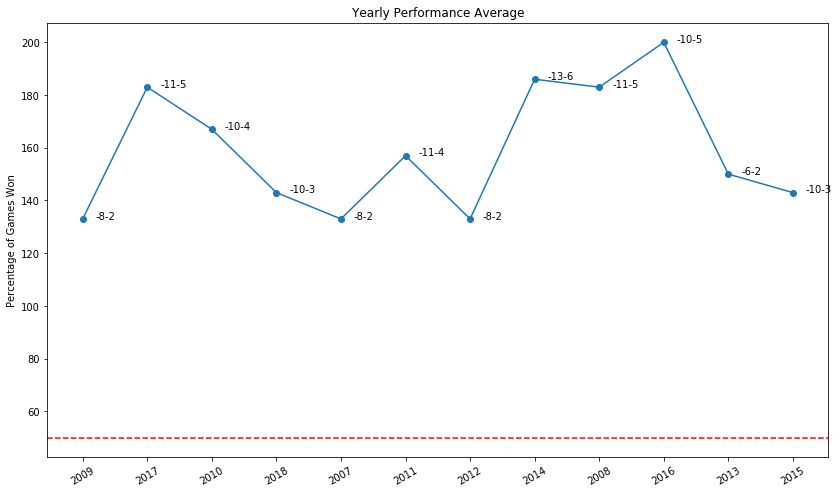

In [18]:
years=svb.yearly_plot(df)

In [19]:
svb.wincount(dframe,years)

Team win-loss record by year:

2009: 11-7
2017: 4-11
2010: 8-11
2018: 11-9
2007: 8-11
2011: 7-11
2012: 9-11
2014: 5-11
2008: 5-11
2016: 3-11
2013: 2-11
2015: 7-11


Total team win-loss-tie: 2-10-0



In [22]:
home,away = svb.location(df,years)

FileNotFoundError: [Errno 2] No such file or directory: '//DREW/Users/andrew/Desktop/mosconi/pkl/dloc'

In [ ]:
svb.location_split(home,away)

In [ ]:
svb.call_em()

In [ ]:
earl=Player('Earl Strickland','America')

In [ ]:
earl.call_em()